### Imports

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
#Function import
# https://towardsdatascience.com/creating-and-training-a-u-net-model-with-pytorch-for-2d-3d-semantic-segmentation-dataset-fb1f7f80fe55
from model import UNet_baysian
from utils import make_one_hot, generate_target, generate_target_swap
from attack import DAG
from random import randint

### Hyperparamters for the attack

In [2]:
num_iterations=20
gamma=0.5
num=15

### Loading model and inputs

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#image_all, label_all=np.load('datasets/OASIS/img.npy'), np.load('datasets/OASIS/lbl.npy')
model=UNet_baysian()
# model.load('./checkpoints/unet_baysian.pkl')
model=model.to(device)

In [4]:
#Load Entire Data
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from PIL import Image
import glob

class OASISDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.subjects = sorted(os.listdir(root_dir))

    def __len__(self):
        return len(self.subjects)

    def __getitem__(self, idx):
        subject_dir = os.path.join(self.root_dir, self.subjects[idx])
        images = sorted(os.listdir(subject_dir+'/PROCESSED/MPRAGE/T88_111'))
        # image_paths = [os.path.join(subject_dir, img_name) for img_name in images]
        # label = int(self.subjects[idx].split("_")[-1])

        # Load and transform the images
        if self.transform:
            transform_images = transforms.Compose([
                self.transform,
                transforms.ToTensor(),
                # transforms.Normalize([0.5], [0.5])
            ])
            
            # transform = transforms.Compose([
            #     transforms.Lambda(lambda x: int(x * 15)) # convert the float label to an integer between 0 and 15
            # ])
            transform_labels = transforms.Compose([
                self.transform,
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 15).int())#transforms.Lambda(lambda x: int(x * 15))
            ])
            # image_list = []
            # for img_path in image_paths:
            #     image = Image.open(img_path).convert('RGB')
            #     image = transform_images(image)
            #     image_list.append(image)
            # images = torch.stack(image_list, dim=0)
            imageFilenamesList = glob.glob(subject_dir+'/PROCESSED/MPRAGE/T88_111/*t88_gfc_tra_90.gif')
            img_path = imageFilenamesList[0]
            images = Image.open(img_path)
            images = transform_images(images)
            
            labelFilenamesList = glob.glob(subject_dir+'/FSL_SEG/*gfc_fseg_tra_90.gif')
            label_path = labelFilenamesList[0]
            label = Image.open(label_path)
            label = transform_labels(label)
            
            

        return images, label

# Define the transformations to apply to the images
transform = transforms.Resize((256, 256))

# Create a DataLoader instance
root_dir = "datasets/OASIS_full/disc1"
dataset = OASISDataset(root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=12, shuffle=True)



In [5]:

print(len(dataset))

77


In [6]:
#Train Model
# Define loss function and optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)


In [7]:
image, label = dataset[0]

In [8]:
image = image.unsqueeze(dim=0)

In [18]:
# calculate mean and std
mean, std = image.mean(), image.std()

In [19]:
mean

tensor(0.1573)

In [11]:
image.unique()

tensor([0.0000, 0.0039, 0.0078, 0.0118, 0.0157, 0.0196, 0.0235, 0.0275, 0.0314,
        0.0353, 0.0392, 0.0431, 0.0471, 0.0510, 0.0549, 0.0588, 0.0627, 0.0667,
        0.0706, 0.0745, 0.0784, 0.0824, 0.0863, 0.0902, 0.0941, 0.0980, 0.1020,
        0.1059, 0.1098, 0.1137, 0.1176, 0.1216, 0.1255, 0.1294, 0.1333, 0.1373,
        0.1412, 0.1451, 0.1490, 0.1529, 0.1569, 0.1608, 0.1647, 0.1686, 0.1725,
        0.1765, 0.1804, 0.1843, 0.1882, 0.1922, 0.1961, 0.2000, 0.2039, 0.2078,
        0.2118, 0.2157, 0.2196, 0.2235, 0.2275, 0.2314, 0.2353, 0.2392, 0.2431,
        0.2471, 0.2510, 0.2549, 0.2588, 0.2627, 0.2667, 0.2706, 0.2745, 0.2784,
        0.2824, 0.2863, 0.2902, 0.2941, 0.2980, 0.3020, 0.3059, 0.3098, 0.3137,
        0.3176, 0.3216, 0.3255, 0.3294, 0.3333, 0.3373, 0.3412, 0.3451, 0.3490,
        0.3529, 0.3569, 0.3608, 0.3647, 0.3686, 0.3725, 0.3765, 0.3804, 0.3843,
        0.3882, 0.3922, 0.3961, 0.4000, 0.4039, 0.4078, 0.4118, 0.4157, 0.4196,
        0.4235, 0.4275, 0.4314, 0.4353, 

In [9]:
image.shape

torch.Size([1, 1, 256, 256])

In [10]:
# Train model
from torch.autograd import Variable
num_epochs = 100
for epoch in range(num_epochs):
    # Training loop
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        print(inputs.shape)
        outputs = model(inputs)
        _,predictions=torch.max(outputs,1)
        predictions.float().requires_grad=True
        # print(predictions.float())
        predictions = Variable(predictions.float(), requires_grad=True)

        # Calculate loss
        # print(criterion(predictions.unsqueeze(dim=1).float(), targets.float()))
        loss = criterion(predictions.unsqueeze(dim=1).float(), targets.float())
        print(outputs.shape)
        print(targets.shape)
        # loss = criterion(outputs, targets.float())

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

    # Print progress
    print("Epoch [{}/{}], Loss: {:.4f}".format(epoch+1, num_epochs, loss.item()))


torch.Size([12, 1, 256, 256])
torch.Size([12, 15, 256, 256])
torch.Size([12, 1, 256, 256])
torch.Size([12, 1, 256, 256])
torch.Size([12, 15, 256, 256])
torch.Size([12, 1, 256, 256])
torch.Size([12, 1, 256, 256])
torch.Size([12, 15, 256, 256])
torch.Size([12, 1, 256, 256])
torch.Size([12, 1, 256, 256])
torch.Size([12, 15, 256, 256])
torch.Size([12, 1, 256, 256])
torch.Size([12, 1, 256, 256])
torch.Size([12, 15, 256, 256])
torch.Size([12, 1, 256, 256])
torch.Size([12, 1, 256, 256])
torch.Size([12, 15, 256, 256])
torch.Size([12, 1, 256, 256])
torch.Size([5, 1, 256, 256])
torch.Size([5, 15, 256, 256])
torch.Size([5, 1, 256, 256])
Epoch [1/100], Loss: -15.9312
torch.Size([12, 1, 256, 256])
torch.Size([12, 15, 256, 256])
torch.Size([12, 1, 256, 256])
torch.Size([12, 1, 256, 256])
torch.Size([12, 15, 256, 256])
torch.Size([12, 1, 256, 256])
torch.Size([12, 1, 256, 256])
torch.Size([12, 15, 256, 256])
torch.Size([12, 1, 256, 256])
torch.Size([12, 1, 256, 256])
torch.Size([12, 15, 256, 256])
to

KeyboardInterrupt: 

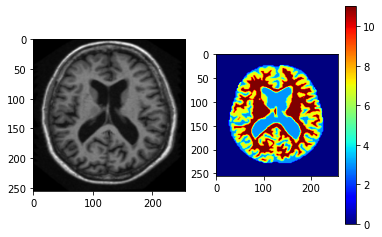

In [10]:
#idx=randint(0,len(image_all)-1)
# image,label=dataset[0]#image_all[idx],label_all[idx]
plt.figure()
plt.subplot(121)
plt.imshow(image[0][0],cmap='gray')
plt.subplot(122)
plt.imshow(label[0],cmap='jet')
plt.colorbar()
plt.show()

In [11]:
image , label = torch.tensor(image, requires_grad=True).float(), torch.tensor(label).float()
image , label = image.to(device), label.to(device)

/tmp/ipykernel_15987/3803926936.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image , label = torch.tensor(image, requires_grad=True).float(), torch.tensor(label).float()


In [12]:
label[0].unique()

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
       device='cuda:0')

In [13]:
label.shape

torch.Size([1, 256, 256])

In [14]:
image.shape

torch.Size([1, 1, 256, 256])

In [15]:
print(model(image))

tensor([[[[-0.0370, -0.5348, -0.6124,  ..., -0.7592, -0.7529, -0.6330],
          [-0.3949, -0.9815, -0.8254,  ..., -0.5130, -0.6990, -0.0173],
          [-0.2884, -0.5778, -0.3232,  ...,  0.0428, -0.0789, -0.2580],
          ...,
          [-0.4000, -0.5039, -0.3430,  ..., -0.1639,  0.0297, -0.1863],
          [-0.4092, -0.4261, -0.2615,  ..., -0.0344,  0.0286, -0.1567],
          [-0.1855, -0.2394, -0.2383,  ..., -0.0537, -0.1919, -0.1595]],

         [[-0.0034,  0.0233, -0.2075,  ..., -0.0459,  0.0791,  0.3775],
          [ 0.2198, -0.3165, -0.2639,  ..., -0.2330, -0.1818,  0.0903],
          [-0.0259, -0.1273,  0.0391,  ...,  0.2627,  0.1055,  0.4518],
          ...,
          [-0.2439, -0.2434,  0.0993,  ...,  0.6139, -0.2015,  0.0636],
          [ 0.0475, -0.0977,  0.1274,  ...,  0.4558, -0.1473,  0.0082],
          [-0.0611, -0.1664, -0.1487,  ..., -0.0365, -0.2154,  0.1206]],

         [[-0.5250, -0.3299, -0.4800,  ..., -0.2014,  0.0324,  0.1065],
          [-0.3174, -0.8735, -

In [18]:
label.shape

torch.Size([1, 256, 256])

### Attacking the model

#### Generating Target
There are two type of targets available:
-  __generate_target__ increases the thickness of the skull
-  __generate_target_swap__ swaps the most common classes

In [19]:
image.unique()

tensor([0.0000, 0.0039, 0.0078, 0.0118, 0.0157, 0.0196, 0.0235, 0.0275, 0.0314,
        0.0353, 0.0392, 0.0431, 0.0471, 0.0510, 0.0549, 0.0588, 0.0627, 0.0667,
        0.0706, 0.0745, 0.0784, 0.0824, 0.0863, 0.0902, 0.0941, 0.0980, 0.1020,
        0.1059, 0.1098, 0.1137, 0.1176, 0.1216, 0.1255, 0.1294, 0.1333, 0.1373,
        0.1412, 0.1451, 0.1490, 0.1529, 0.1569, 0.1608, 0.1647, 0.1686, 0.1725,
        0.1765, 0.1804, 0.1843, 0.1882, 0.1922, 0.1961, 0.2000, 0.2039, 0.2078,
        0.2118, 0.2157, 0.2196, 0.2235, 0.2275, 0.2314, 0.2353, 0.2392, 0.2431,
        0.2471, 0.2510, 0.2549, 0.2588, 0.2627, 0.2667, 0.2706, 0.2745, 0.2784,
        0.2824, 0.2863, 0.2902, 0.2941, 0.2980, 0.3020, 0.3059, 0.3098, 0.3137,
        0.3176, 0.3216, 0.3255, 0.3294, 0.3333, 0.3373, 0.3412, 0.3451, 0.3490,
        0.3529, 0.3569, 0.3608, 0.3647, 0.3686, 0.3725, 0.3765, 0.3804, 0.3843,
        0.3882, 0.3922, 0.3961, 0.4000, 0.4039, 0.4078, 0.4118, 0.4157, 0.4196,
        0.4235, 0.4275, 0.4314, 0.4353, 

In [26]:
np.unique(adv)

array([0])

In [25]:
adv_target.shape

torch.Size([1, 1, 256, 256])

In [16]:
label_oh=make_one_hot(label.long(),15,device)

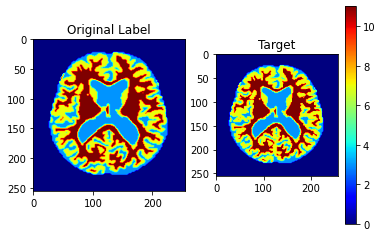

In [17]:
# Change labels from [batch_size, height, width] to [batch_size, num_classes, height, width]
# label_oh=make_one_hot(label.long(),15,device)
adv_target=generate_target_swap(label_oh.cpu().numpy())
adv_target=torch.from_numpy(adv_target).float()
adv_target=adv_target.to(device)

#Visualizing the target
_, adv=torch.max(adv_target,1)
adv=adv.cpu().numpy()
plt.figure()
plt.subplot(121)
plt.title('Original Label')
plt.imshow(label[0].cpu().numpy(),cmap='jet')
plt.subplot(122)
plt.title('Target')
plt.imshow(adv[0],cmap='jet')
plt.colorbar()
plt.show()

In [18]:
label_oh.shape

torch.Size([1, 15, 256, 256])

In [19]:
label_oh.shape

torch.Size([1, 15, 256, 256])

In [20]:
label_oh.unique()

tensor([0., 1.], device='cuda:0')

In [21]:
image_adv,output_clean, noise_total, noise_iteration, prediction_iteration, image_iteration=DAG(model=model,
              image=image,
              ground_truth=label_oh,
              adv_target=adv_target,
              num_iterations=num_iterations,
              gamma=gamma,
              no_background=True,
              background_class=0,
              device=device,
              verbose=False)

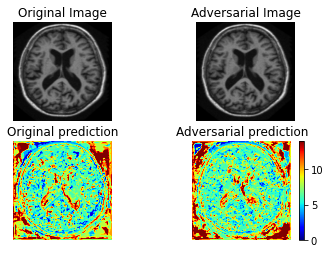

In [22]:
plt.figure()
plt.subplot(221)
plt.title('Original Image')
plt.imshow(image_iteration[0],cmap='gray')
plt.axis('off')
plt.subplot(222)
plt.title('Adversarial Image')
plt.imshow(image_iteration[-1],cmap='gray')
plt.axis('off')
plt.subplot(223)
plt.title('Original prediction')
plt.imshow(prediction_iteration[0],cmap='jet')
plt.axis('off')
plt.subplot(224)
plt.title('Adversarial prediction')
plt.imshow(prediction_iteration[-1],cmap='jet')
plt.axis('off')
plt.colorbar()
plt.show()